# Face Generation
This project will use generative adversarial networks to generate new images of faces.
### Get the Data
Two datasets will be used in this project:
- MNIST
- CelebA


In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

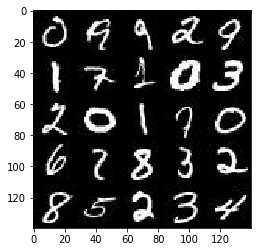

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

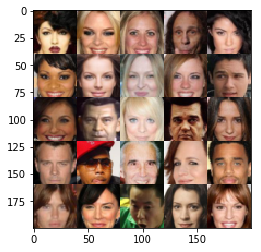

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 40, 40, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)<br/>
**Sai: Rank means number of valuables**

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    # For discriminator
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    # For generator
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    input_lr = tf.placeholder(tf.float32, name='input_lr')
    
    return inputs_real, inputs_z, input_lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [45]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2 # Alpha for Leaky ReLU
    # print(images)
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3, Kernel size 5x5
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1) # leaky ReLU.
        # 14x14x64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3) # N units in this layer.
        # 4x4x256

        # Flatten it, 姐係Reshape it into one long vector 
        flat = tf.reshape(relu3, (-1, 4*4*256)) #  4096 units in this layer.
        logits = tf.layers.dense(flat, 1) # fully connected layer，【 Only one unit】
        out = tf.sigmoid(logits) # sigmoid cross entropy loss calculation
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [81]:
# Sai: This time, it's assumed that reuse=False for training and reuse=True for inference
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2 # Alpha for Leaky ReLU
    # print(z)
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512) #第一件平面野。
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512)) #第二件立體長條野。
        # x1 = tf.layers.batch_normalization(x1, training=is_train) #Batch normalization
        x1 = tf.maximum(alpha * x1, x1) # Leaky ReLU
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 28, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x28 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xOut_channel_dim now
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [82]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    
    zeros_like: Creates a tensor with all elements set to 0.
    ones_like: Creates a tensor with all elements set to 1.
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [83]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    """"
    print("===============Start Optimizers===============")
    print("Variable of discriminator:")
    for d_var in d_vars:
        print(d_var.name)
    print("\nVariable of generator:")
    for g_var in g_vars:
        print(g_var.name)
    print("===============End Optimizers===============")
    """

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [84]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [86]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    #====================Init Part Start=============================
    steps = 0
    show_every = 100 #Recommended to print the generator output every 100 batches   
    print_every = 10  
    
    #(image_width, image_height, image_channels, z_dim)
    
    n_samples, width, height, channels = data_shape
    input_real, input_z, input_lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)
    #====================Init Part End=============================
    
    with tf.Session() as sess:
        # saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    # losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    n_images = 25
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

    #    saver.save(sess, './checkpoints/generator.ckpt')

    #with open('samples.pkl', 'wb') as f:
    #    pkl.dump(samples, f)
    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.3529... Generator Loss: 1.7011
Epoch 0/2... Discriminator Loss: 1.6074... Generator Loss: 0.5936
Epoch 0/2... Discriminator Loss: 0.9963... Generator Loss: 0.9465
Epoch 0/2... Discriminator Loss: 1.0408... Generator Loss: 1.0673
Epoch 0/2... Discriminator Loss: 1.2708... Generator Loss: 0.4532
Epoch 0/2... Discriminator Loss: 0.7908... Generator Loss: 1.1342
Epoch 0/2... Discriminator Loss: 0.8518... Generator Loss: 0.9085
Epoch 0/2... Discriminator Loss: 0.8862... Generator Loss: 0.7493
Epoch 0/2... Discriminator Loss: 0.5988... Generator Loss: 1.6510
Epoch 0/2... Discriminator Loss: 0.9425... Generator Loss: 3.2277


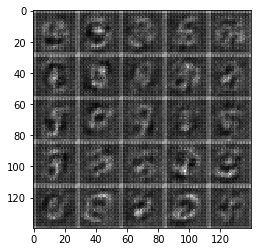

Epoch 0/2... Discriminator Loss: 0.9785... Generator Loss: 0.5607
Epoch 0/2... Discriminator Loss: 0.4214... Generator Loss: 2.6535
Epoch 0/2... Discriminator Loss: 1.3136... Generator Loss: 0.3609
Epoch 0/2... Discriminator Loss: 0.2593... Generator Loss: 2.8853
Epoch 0/2... Discriminator Loss: 0.4901... Generator Loss: 1.1977
Epoch 0/2... Discriminator Loss: 2.0580... Generator Loss: 0.1699
Epoch 0/2... Discriminator Loss: 0.5793... Generator Loss: 5.5373
Epoch 0/2... Discriminator Loss: 0.4568... Generator Loss: 1.2137
Epoch 0/2... Discriminator Loss: 1.3392... Generator Loss: 0.4131
Epoch 0/2... Discriminator Loss: 0.1797... Generator Loss: 2.7855


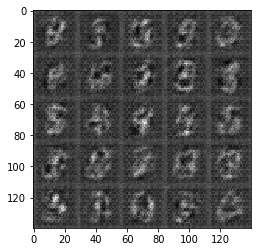

Epoch 0/2... Discriminator Loss: 1.3596... Generator Loss: 8.2312
Epoch 0/2... Discriminator Loss: 0.8998... Generator Loss: 0.7192
Epoch 0/2... Discriminator Loss: 0.5116... Generator Loss: 1.3081
Epoch 0/2... Discriminator Loss: 0.2689... Generator Loss: 3.2931
Epoch 0/2... Discriminator Loss: 0.3671... Generator Loss: 3.1152
Epoch 0/2... Discriminator Loss: 0.4063... Generator Loss: 1.7685
Epoch 0/2... Discriminator Loss: 0.2530... Generator Loss: 2.0219
Epoch 0/2... Discriminator Loss: 0.3977... Generator Loss: 1.4248
Epoch 0/2... Discriminator Loss: 0.2442... Generator Loss: 2.0028
Epoch 0/2... Discriminator Loss: 0.1850... Generator Loss: 4.3407


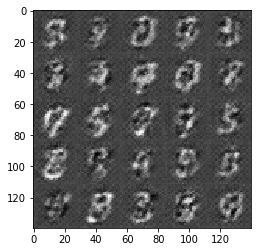

Epoch 0/2... Discriminator Loss: 0.1158... Generator Loss: 2.9981
Epoch 0/2... Discriminator Loss: 0.2360... Generator Loss: 2.6501
Epoch 0/2... Discriminator Loss: 0.2709... Generator Loss: 1.8519
Epoch 0/2... Discriminator Loss: 0.2189... Generator Loss: 3.0186
Epoch 0/2... Discriminator Loss: 0.0800... Generator Loss: 3.4814
Epoch 0/2... Discriminator Loss: 0.1351... Generator Loss: 2.6641
Epoch 0/2... Discriminator Loss: 0.1785... Generator Loss: 2.2863
Epoch 0/2... Discriminator Loss: 0.1737... Generator Loss: 2.2589
Epoch 0/2... Discriminator Loss: 0.9332... Generator Loss: 0.6086
Epoch 0/2... Discriminator Loss: 0.4850... Generator Loss: 1.3295


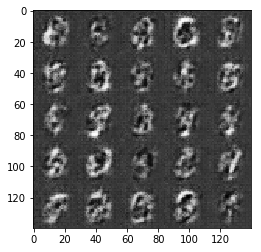

Epoch 0/2... Discriminator Loss: 0.3619... Generator Loss: 1.7675
Epoch 0/2... Discriminator Loss: 0.2466... Generator Loss: 2.0858
Epoch 0/2... Discriminator Loss: 0.2285... Generator Loss: 2.0869
Epoch 0/2... Discriminator Loss: 0.2463... Generator Loss: 1.9138
Epoch 0/2... Discriminator Loss: 0.1112... Generator Loss: 3.2264
Epoch 0/2... Discriminator Loss: 0.1469... Generator Loss: 2.4068
Epoch 0/2... Discriminator Loss: 0.0881... Generator Loss: 2.9653
Epoch 0/2... Discriminator Loss: 0.0999... Generator Loss: 2.9049
Epoch 0/2... Discriminator Loss: 0.0644... Generator Loss: 3.7905
Epoch 0/2... Discriminator Loss: 0.1150... Generator Loss: 2.8227


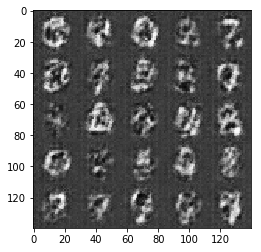

Epoch 0/2... Discriminator Loss: 0.0820... Generator Loss: 3.6289
Epoch 0/2... Discriminator Loss: 0.0627... Generator Loss: 3.4280
Epoch 0/2... Discriminator Loss: 0.0655... Generator Loss: 3.4264
Epoch 0/2... Discriminator Loss: 0.0474... Generator Loss: 4.0668
Epoch 0/2... Discriminator Loss: 0.0671... Generator Loss: 3.5017
Epoch 0/2... Discriminator Loss: 0.0394... Generator Loss: 4.2797
Epoch 0/2... Discriminator Loss: 0.0506... Generator Loss: 4.1242
Epoch 0/2... Discriminator Loss: 0.0733... Generator Loss: 3.0829
Epoch 0/2... Discriminator Loss: 0.8633... Generator Loss: 1.7021
Epoch 0/2... Discriminator Loss: 0.6786... Generator Loss: 1.0644


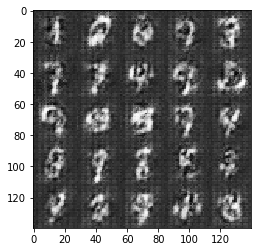

Epoch 0/2... Discriminator Loss: 0.4827... Generator Loss: 1.7022
Epoch 0/2... Discriminator Loss: 0.3208... Generator Loss: 1.6744
Epoch 0/2... Discriminator Loss: 0.2469... Generator Loss: 2.0421
Epoch 0/2... Discriminator Loss: 0.2864... Generator Loss: 1.7591
Epoch 0/2... Discriminator Loss: 0.2195... Generator Loss: 2.3634
Epoch 0/2... Discriminator Loss: 0.2446... Generator Loss: 2.0050
Epoch 0/2... Discriminator Loss: 0.1635... Generator Loss: 2.5166
Epoch 0/2... Discriminator Loss: 0.3119... Generator Loss: 1.7848
Epoch 0/2... Discriminator Loss: 0.2239... Generator Loss: 2.1831
Epoch 0/2... Discriminator Loss: 0.1467... Generator Loss: 2.5093


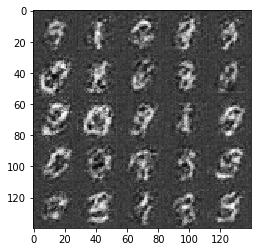

Epoch 0/2... Discriminator Loss: 0.2340... Generator Loss: 1.9044
Epoch 0/2... Discriminator Loss: 0.3629... Generator Loss: 1.4153
Epoch 0/2... Discriminator Loss: 0.2821... Generator Loss: 1.6817
Epoch 0/2... Discriminator Loss: 0.1590... Generator Loss: 2.5161
Epoch 0/2... Discriminator Loss: 0.1523... Generator Loss: 2.4117
Epoch 0/2... Discriminator Loss: 0.2054... Generator Loss: 2.1265
Epoch 0/2... Discriminator Loss: 0.1729... Generator Loss: 2.3309
Epoch 0/2... Discriminator Loss: 0.2218... Generator Loss: 2.0150
Epoch 0/2... Discriminator Loss: 0.1539... Generator Loss: 2.3611
Epoch 0/2... Discriminator Loss: 0.1401... Generator Loss: 2.6046


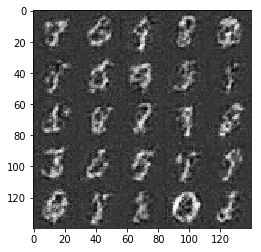

Epoch 0/2... Discriminator Loss: 0.1218... Generator Loss: 2.6944
Epoch 0/2... Discriminator Loss: 0.1230... Generator Loss: 2.7044
Epoch 0/2... Discriminator Loss: 0.1208... Generator Loss: 2.6811
Epoch 0/2... Discriminator Loss: 0.1699... Generator Loss: 2.3374
Epoch 0/2... Discriminator Loss: 0.1140... Generator Loss: 2.7898
Epoch 0/2... Discriminator Loss: 0.0955... Generator Loss: 2.8189
Epoch 0/2... Discriminator Loss: 0.1359... Generator Loss: 2.8461
Epoch 0/2... Discriminator Loss: 0.1280... Generator Loss: 2.6488
Epoch 0/2... Discriminator Loss: 0.1115... Generator Loss: 2.9215
Epoch 0/2... Discriminator Loss: 0.0836... Generator Loss: 3.1238


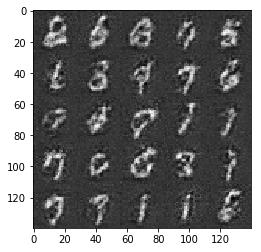

Epoch 0/2... Discriminator Loss: 0.1268... Generator Loss: 2.6280
Epoch 0/2... Discriminator Loss: 0.0569... Generator Loss: 3.8456
Epoch 0/2... Discriminator Loss: 0.1748... Generator Loss: 2.4415
Epoch 1/2... Discriminator Loss: 0.0602... Generator Loss: 3.9264
Epoch 1/2... Discriminator Loss: 0.1872... Generator Loss: 2.1417
Epoch 1/2... Discriminator Loss: 0.1088... Generator Loss: 3.0850
Epoch 1/2... Discriminator Loss: 0.1940... Generator Loss: 2.0609
Epoch 1/2... Discriminator Loss: 0.0829... Generator Loss: 3.2476
Epoch 1/2... Discriminator Loss: 15.4432... Generator Loss: 14.9406
Epoch 1/2... Discriminator Loss: 0.8730... Generator Loss: 1.0388


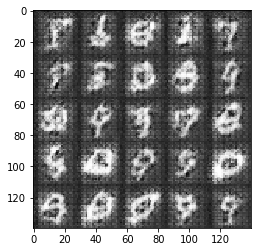

Epoch 1/2... Discriminator Loss: 1.2861... Generator Loss: 1.4537
Epoch 1/2... Discriminator Loss: 0.9750... Generator Loss: 1.1020
Epoch 1/2... Discriminator Loss: 0.9456... Generator Loss: 1.3269
Epoch 1/2... Discriminator Loss: 0.9393... Generator Loss: 1.7639
Epoch 1/2... Discriminator Loss: 0.7989... Generator Loss: 1.4380
Epoch 1/2... Discriminator Loss: 0.8654... Generator Loss: 1.7601
Epoch 1/2... Discriminator Loss: 0.6973... Generator Loss: 1.3115
Epoch 1/2... Discriminator Loss: 0.7979... Generator Loss: 2.4426
Epoch 1/2... Discriminator Loss: 0.9295... Generator Loss: 3.3029
Epoch 1/2... Discriminator Loss: 0.6165... Generator Loss: 1.0732


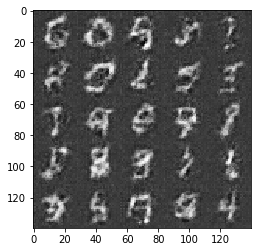

Epoch 1/2... Discriminator Loss: 0.5235... Generator Loss: 2.8805
Epoch 1/2... Discriminator Loss: 0.3946... Generator Loss: 1.4466
Epoch 1/2... Discriminator Loss: 1.0795... Generator Loss: 5.0328
Epoch 1/2... Discriminator Loss: 0.2569... Generator Loss: 1.9072
Epoch 1/2... Discriminator Loss: 0.1800... Generator Loss: 2.7531
Epoch 1/2... Discriminator Loss: 0.1597... Generator Loss: 2.6089
Epoch 1/2... Discriminator Loss: 0.1341... Generator Loss: 3.1053
Epoch 1/2... Discriminator Loss: 0.1430... Generator Loss: 2.3067
Epoch 1/2... Discriminator Loss: 0.0724... Generator Loss: 3.2581
Epoch 1/2... Discriminator Loss: 0.0863... Generator Loss: 2.9711


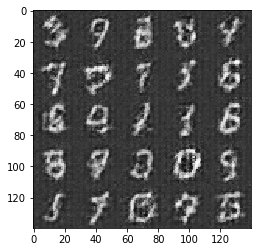

Epoch 1/2... Discriminator Loss: 0.0451... Generator Loss: 3.7728
Epoch 1/2... Discriminator Loss: 0.0728... Generator Loss: 3.2012
Epoch 1/2... Discriminator Loss: 0.0904... Generator Loss: 2.9448
Epoch 1/2... Discriminator Loss: 0.0554... Generator Loss: 4.1388
Epoch 1/2... Discriminator Loss: 0.1446... Generator Loss: 2.3101
Epoch 1/2... Discriminator Loss: 0.1148... Generator Loss: 2.6813
Epoch 1/2... Discriminator Loss: 0.0664... Generator Loss: 3.5023
Epoch 1/2... Discriminator Loss: 0.0294... Generator Loss: 4.4989
Epoch 1/2... Discriminator Loss: 0.0300... Generator Loss: 4.3141
Epoch 1/2... Discriminator Loss: 0.0897... Generator Loss: 2.8508


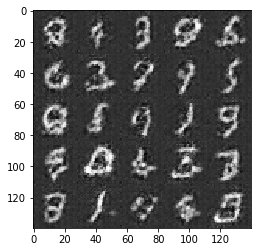

Epoch 1/2... Discriminator Loss: 0.0563... Generator Loss: 4.0540
Epoch 1/2... Discriminator Loss: 0.1023... Generator Loss: 2.7373
Epoch 1/2... Discriminator Loss: 0.0414... Generator Loss: 4.0651
Epoch 1/2... Discriminator Loss: 0.0674... Generator Loss: 3.1981
Epoch 1/2... Discriminator Loss: 0.0537... Generator Loss: 3.3565
Epoch 1/2... Discriminator Loss: 0.0471... Generator Loss: 3.8521
Epoch 1/2... Discriminator Loss: 0.0595... Generator Loss: 3.4722
Epoch 1/2... Discriminator Loss: 0.0470... Generator Loss: 3.7131
Epoch 1/2... Discriminator Loss: 0.1095... Generator Loss: 6.2935
Epoch 1/2... Discriminator Loss: 0.8244... Generator Loss: 0.7733


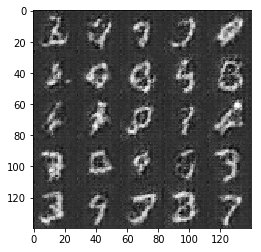

Epoch 1/2... Discriminator Loss: 0.3268... Generator Loss: 2.2002
Epoch 1/2... Discriminator Loss: 0.3113... Generator Loss: 1.8799
Epoch 1/2... Discriminator Loss: 0.1876... Generator Loss: 2.6529
Epoch 1/2... Discriminator Loss: 0.2363... Generator Loss: 2.0355
Epoch 1/2... Discriminator Loss: 0.1398... Generator Loss: 2.6835
Epoch 1/2... Discriminator Loss: 0.2064... Generator Loss: 2.0586
Epoch 1/2... Discriminator Loss: 0.1689... Generator Loss: 2.4700
Epoch 1/2... Discriminator Loss: 0.0978... Generator Loss: 2.8923
Epoch 1/2... Discriminator Loss: 0.0995... Generator Loss: 3.3030
Epoch 1/2... Discriminator Loss: 0.0958... Generator Loss: 2.8906


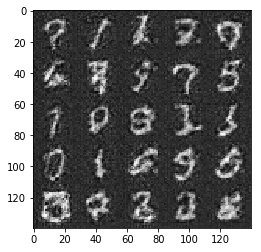

Epoch 1/2... Discriminator Loss: 0.0609... Generator Loss: 3.4529
Epoch 1/2... Discriminator Loss: 0.1647... Generator Loss: 2.4683
Epoch 1/2... Discriminator Loss: 0.0971... Generator Loss: 2.8727
Epoch 1/2... Discriminator Loss: 0.1693... Generator Loss: 2.3444
Epoch 1/2... Discriminator Loss: 0.1849... Generator Loss: 2.1742
Epoch 1/2... Discriminator Loss: 0.1667... Generator Loss: 2.3025
Epoch 1/2... Discriminator Loss: 0.2633... Generator Loss: 1.8487
Epoch 1/2... Discriminator Loss: 0.1937... Generator Loss: 2.2313
Epoch 1/2... Discriminator Loss: 0.0957... Generator Loss: 2.7355
Epoch 1/2... Discriminator Loss: 0.1272... Generator Loss: 2.5134


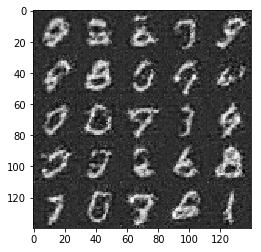

Epoch 1/2... Discriminator Loss: 0.0887... Generator Loss: 2.8455
Epoch 1/2... Discriminator Loss: 0.0366... Generator Loss: 4.0977
Epoch 1/2... Discriminator Loss: 0.0536... Generator Loss: 3.6418
Epoch 1/2... Discriminator Loss: 0.0443... Generator Loss: 3.7342
Epoch 1/2... Discriminator Loss: 0.0845... Generator Loss: 2.9181
Epoch 1/2... Discriminator Loss: 0.1290... Generator Loss: 2.6158
Epoch 1/2... Discriminator Loss: 0.0737... Generator Loss: 2.9550
Epoch 1/2... Discriminator Loss: 0.1095... Generator Loss: 2.6850
Epoch 1/2... Discriminator Loss: 0.0423... Generator Loss: 3.7569
Epoch 1/2... Discriminator Loss: 0.0586... Generator Loss: 3.4320


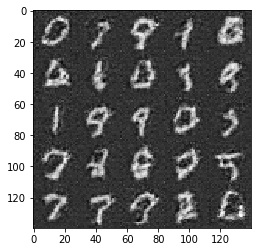

Epoch 1/2... Discriminator Loss: 0.0499... Generator Loss: 3.6821
Epoch 1/2... Discriminator Loss: 0.1185... Generator Loss: 2.6142
Epoch 1/2... Discriminator Loss: 0.0688... Generator Loss: 3.7098
Epoch 1/2... Discriminator Loss: 0.0419... Generator Loss: 3.8544
Epoch 1/2... Discriminator Loss: 0.1096... Generator Loss: 2.7895
Epoch 1/2... Discriminator Loss: 0.1244... Generator Loss: 2.4963
Epoch 1/2... Discriminator Loss: 0.0256... Generator Loss: 4.5005
Epoch 1/2... Discriminator Loss: 0.1928... Generator Loss: 2.1123
Epoch 1/2... Discriminator Loss: 1.8557... Generator Loss: 0.4561
Epoch 1/2... Discriminator Loss: 0.7778... Generator Loss: 0.9818


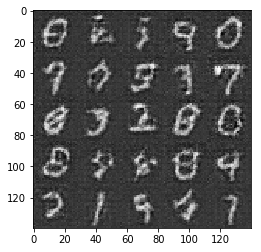

Epoch 1/2... Discriminator Loss: 0.5135... Generator Loss: 1.1552
Epoch 1/2... Discriminator Loss: 0.2365... Generator Loss: 2.2500
Epoch 1/2... Discriminator Loss: 0.3061... Generator Loss: 1.6065
Epoch 1/2... Discriminator Loss: 0.8917... Generator Loss: 1.0359
Epoch 1/2... Discriminator Loss: 0.9757... Generator Loss: 1.0797
Epoch 1/2... Discriminator Loss: 0.7386... Generator Loss: 1.3801
Epoch 1/2... Discriminator Loss: 0.9055... Generator Loss: 1.2715


In [60]:
batch_size = 64
z_dim = 50
learning_rate = 0.0002
beta1 = 0.5 # For Adam Optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 1.5841... Generator Loss: 0.2829
Epoch 0/1... Discriminator Loss: 0.0291... Generator Loss: 3.7928
Epoch 0/1... Discriminator Loss: 0.0196... Generator Loss: 7.8443
Epoch 0/1... Discriminator Loss: 0.0652... Generator Loss: 22.0538
Epoch 0/1... Discriminator Loss: 0.0493... Generator Loss: 3.3242
Epoch 0/1... Discriminator Loss: 0.1646... Generator Loss: 4.0959
Epoch 0/1... Discriminator Loss: 0.0544... Generator Loss: 3.8945
Epoch 0/1... Discriminator Loss: 0.0679... Generator Loss: 13.7719
Epoch 0/1... Discriminator Loss: 0.1099... Generator Loss: 4.7160
Epoch 0/1... Discriminator Loss: 0.5735... Generator Loss: 1.2504


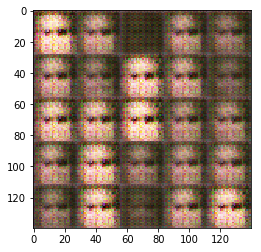

Epoch 0/1... Discriminator Loss: 0.5984... Generator Loss: 1.3059
Epoch 0/1... Discriminator Loss: 0.7591... Generator Loss: 9.9175
Epoch 0/1... Discriminator Loss: 0.0581... Generator Loss: 6.1702
Epoch 0/1... Discriminator Loss: 0.1024... Generator Loss: 2.6596
Epoch 0/1... Discriminator Loss: 0.5505... Generator Loss: 1.3322
Epoch 0/1... Discriminator Loss: 0.0312... Generator Loss: 5.4902
Epoch 0/1... Discriminator Loss: 0.1993... Generator Loss: 2.3408
Epoch 0/1... Discriminator Loss: 3.0203... Generator Loss: 7.1360
Epoch 0/1... Discriminator Loss: 0.5078... Generator Loss: 3.0797
Epoch 0/1... Discriminator Loss: 0.8267... Generator Loss: 2.1133


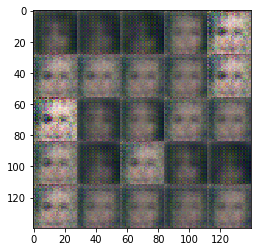

Epoch 0/1... Discriminator Loss: 1.0324... Generator Loss: 1.3841
Epoch 0/1... Discriminator Loss: 0.7426... Generator Loss: 1.0945
Epoch 0/1... Discriminator Loss: 1.0306... Generator Loss: 1.0012
Epoch 0/1... Discriminator Loss: 0.2639... Generator Loss: 2.2500
Epoch 0/1... Discriminator Loss: 1.1256... Generator Loss: 3.1893
Epoch 0/1... Discriminator Loss: 0.3307... Generator Loss: 1.9936
Epoch 0/1... Discriminator Loss: 0.7210... Generator Loss: 6.3282
Epoch 0/1... Discriminator Loss: 0.4466... Generator Loss: 1.4451
Epoch 0/1... Discriminator Loss: 0.7173... Generator Loss: 1.3875
Epoch 0/1... Discriminator Loss: 0.8129... Generator Loss: 0.8616


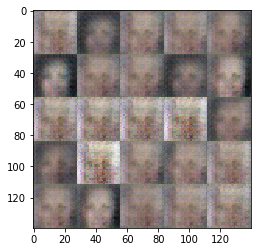

Epoch 0/1... Discriminator Loss: 0.3821... Generator Loss: 1.5805
Epoch 0/1... Discriminator Loss: 0.4379... Generator Loss: 4.8563
Epoch 0/1... Discriminator Loss: 0.4875... Generator Loss: 2.3007
Epoch 0/1... Discriminator Loss: 0.5285... Generator Loss: 1.7164
Epoch 0/1... Discriminator Loss: 0.5453... Generator Loss: 2.2578
Epoch 0/1... Discriminator Loss: 0.7311... Generator Loss: 1.8922
Epoch 0/1... Discriminator Loss: 0.7413... Generator Loss: 3.9160
Epoch 0/1... Discriminator Loss: 0.3178... Generator Loss: 2.9936
Epoch 0/1... Discriminator Loss: 0.3211... Generator Loss: 3.2042
Epoch 0/1... Discriminator Loss: 0.5416... Generator Loss: 1.8128


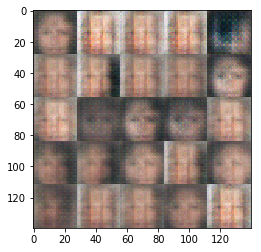

Epoch 0/1... Discriminator Loss: 0.5315... Generator Loss: 1.2796
Epoch 0/1... Discriminator Loss: 0.4890... Generator Loss: 1.3558
Epoch 0/1... Discriminator Loss: 1.1429... Generator Loss: 2.2728
Epoch 0/1... Discriminator Loss: 0.5086... Generator Loss: 2.6456
Epoch 0/1... Discriminator Loss: 0.4087... Generator Loss: 2.0215
Epoch 0/1... Discriminator Loss: 1.2288... Generator Loss: 2.7217
Epoch 0/1... Discriminator Loss: 2.7762... Generator Loss: 4.8517
Epoch 0/1... Discriminator Loss: 0.6531... Generator Loss: 1.2338
Epoch 0/1... Discriminator Loss: 0.5333... Generator Loss: 1.5584
Epoch 0/1... Discriminator Loss: 0.5665... Generator Loss: 2.0676


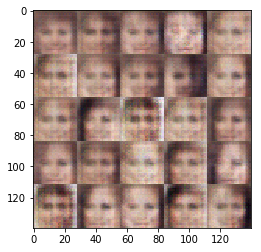

Epoch 0/1... Discriminator Loss: 0.4127... Generator Loss: 2.0848
Epoch 0/1... Discriminator Loss: 1.6035... Generator Loss: 0.3520
Epoch 0/1... Discriminator Loss: 0.5845... Generator Loss: 1.4953
Epoch 0/1... Discriminator Loss: 0.7958... Generator Loss: 1.0759
Epoch 0/1... Discriminator Loss: 0.3437... Generator Loss: 3.1563
Epoch 0/1... Discriminator Loss: 0.4008... Generator Loss: 1.4940
Epoch 0/1... Discriminator Loss: 0.5381... Generator Loss: 1.0488
Epoch 0/1... Discriminator Loss: 0.4962... Generator Loss: 1.7175
Epoch 0/1... Discriminator Loss: 0.3153... Generator Loss: 2.1332
Epoch 0/1... Discriminator Loss: 0.4901... Generator Loss: 2.1288


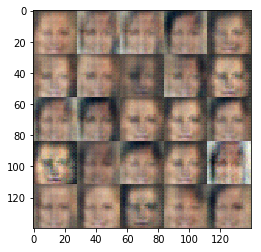

Epoch 0/1... Discriminator Loss: 0.5892... Generator Loss: 1.3396
Epoch 0/1... Discriminator Loss: 0.5208... Generator Loss: 1.6843
Epoch 0/1... Discriminator Loss: 0.2184... Generator Loss: 2.3771
Epoch 0/1... Discriminator Loss: 0.7038... Generator Loss: 1.0635
Epoch 0/1... Discriminator Loss: 0.2759... Generator Loss: 2.1996
Epoch 0/1... Discriminator Loss: 0.6846... Generator Loss: 2.1879
Epoch 0/1... Discriminator Loss: 0.2919... Generator Loss: 2.8514
Epoch 0/1... Discriminator Loss: 0.8605... Generator Loss: 0.8997
Epoch 0/1... Discriminator Loss: 0.4849... Generator Loss: 1.7297
Epoch 0/1... Discriminator Loss: 0.3094... Generator Loss: 2.0331


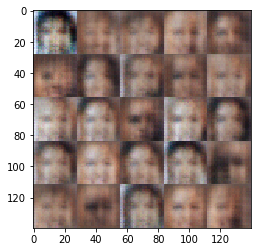

Epoch 0/1... Discriminator Loss: 0.3040... Generator Loss: 3.3205
Epoch 0/1... Discriminator Loss: 0.3621... Generator Loss: 2.4513
Epoch 0/1... Discriminator Loss: 0.6044... Generator Loss: 2.2550
Epoch 0/1... Discriminator Loss: 0.3518... Generator Loss: 2.3212
Epoch 0/1... Discriminator Loss: 0.3366... Generator Loss: 2.3116
Epoch 0/1... Discriminator Loss: 0.4186... Generator Loss: 2.0625
Epoch 0/1... Discriminator Loss: 0.4360... Generator Loss: 3.7395
Epoch 0/1... Discriminator Loss: 0.2005... Generator Loss: 2.8179
Epoch 0/1... Discriminator Loss: 0.1568... Generator Loss: 4.1158
Epoch 0/1... Discriminator Loss: 0.3167... Generator Loss: 2.2442


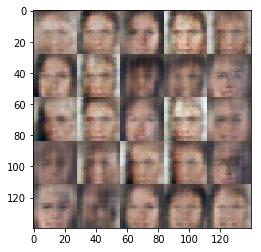

Epoch 0/1... Discriminator Loss: 0.8839... Generator Loss: 0.8063
Epoch 0/1... Discriminator Loss: 0.3199... Generator Loss: 2.0713
Epoch 0/1... Discriminator Loss: 0.5396... Generator Loss: 1.3155
Epoch 0/1... Discriminator Loss: 0.6912... Generator Loss: 1.4219
Epoch 0/1... Discriminator Loss: 0.2250... Generator Loss: 2.7541
Epoch 0/1... Discriminator Loss: 1.6112... Generator Loss: 0.5311
Epoch 0/1... Discriminator Loss: 0.9068... Generator Loss: 0.8750
Epoch 0/1... Discriminator Loss: 0.4528... Generator Loss: 1.6690
Epoch 0/1... Discriminator Loss: 0.4115... Generator Loss: 1.5119
Epoch 0/1... Discriminator Loss: 0.4836... Generator Loss: 1.2750


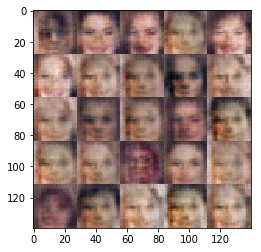

Epoch 0/1... Discriminator Loss: 0.4160... Generator Loss: 2.4005
Epoch 0/1... Discriminator Loss: 0.3590... Generator Loss: 2.0051
Epoch 0/1... Discriminator Loss: 1.5930... Generator Loss: 5.0520
Epoch 0/1... Discriminator Loss: 0.5612... Generator Loss: 3.6675
Epoch 0/1... Discriminator Loss: 0.7812... Generator Loss: 1.0384
Epoch 0/1... Discriminator Loss: 0.2575... Generator Loss: 3.3527
Epoch 0/1... Discriminator Loss: 0.2193... Generator Loss: 2.9984
Epoch 0/1... Discriminator Loss: 0.5444... Generator Loss: 1.7871
Epoch 0/1... Discriminator Loss: 0.4533... Generator Loss: 1.7516
Epoch 0/1... Discriminator Loss: 0.2523... Generator Loss: 2.9220


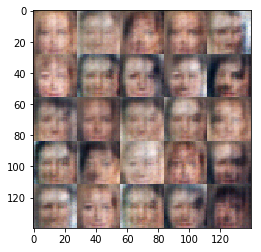

Epoch 0/1... Discriminator Loss: 1.4228... Generator Loss: 4.6944
Epoch 0/1... Discriminator Loss: 0.5169... Generator Loss: 1.4609
Epoch 0/1... Discriminator Loss: 0.4520... Generator Loss: 1.6620
Epoch 0/1... Discriminator Loss: 0.3943... Generator Loss: 3.5848
Epoch 0/1... Discriminator Loss: 0.6353... Generator Loss: 1.5395
Epoch 0/1... Discriminator Loss: 0.3113... Generator Loss: 2.2042
Epoch 0/1... Discriminator Loss: 0.5630... Generator Loss: 1.2331
Epoch 0/1... Discriminator Loss: 0.4931... Generator Loss: 3.4835
Epoch 0/1... Discriminator Loss: 0.4165... Generator Loss: 1.7850
Epoch 0/1... Discriminator Loss: 0.7465... Generator Loss: 5.1943


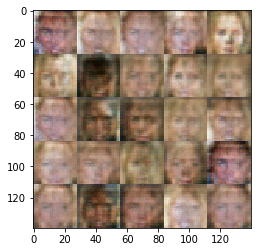

Epoch 0/1... Discriminator Loss: 1.3202... Generator Loss: 0.6570
Epoch 0/1... Discriminator Loss: 0.3824... Generator Loss: 2.7074
Epoch 0/1... Discriminator Loss: 0.3178... Generator Loss: 2.2162
Epoch 0/1... Discriminator Loss: 0.3755... Generator Loss: 2.1233
Epoch 0/1... Discriminator Loss: 0.3095... Generator Loss: 2.4881
Epoch 0/1... Discriminator Loss: 0.4912... Generator Loss: 1.6087
Epoch 0/1... Discriminator Loss: 0.3929... Generator Loss: 1.6892
Epoch 0/1... Discriminator Loss: 0.6552... Generator Loss: 2.3779
Epoch 0/1... Discriminator Loss: 0.4759... Generator Loss: 1.5392
Epoch 0/1... Discriminator Loss: 0.3993... Generator Loss: 1.6598


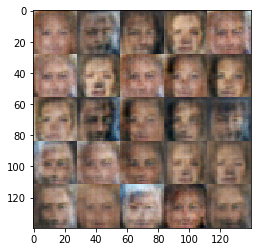

Epoch 0/1... Discriminator Loss: 0.3296... Generator Loss: 2.6203
Epoch 0/1... Discriminator Loss: 0.8188... Generator Loss: 0.8515
Epoch 0/1... Discriminator Loss: 0.3144... Generator Loss: 2.0931
Epoch 0/1... Discriminator Loss: 0.3098... Generator Loss: 2.9069
Epoch 0/1... Discriminator Loss: 0.1667... Generator Loss: 2.9711
Epoch 0/1... Discriminator Loss: 0.3569... Generator Loss: 2.1951
Epoch 0/1... Discriminator Loss: 0.4746... Generator Loss: 2.8886
Epoch 0/1... Discriminator Loss: 0.3116... Generator Loss: 1.9289
Epoch 0/1... Discriminator Loss: 0.1461... Generator Loss: 3.1388
Epoch 0/1... Discriminator Loss: 0.3682... Generator Loss: 1.5282


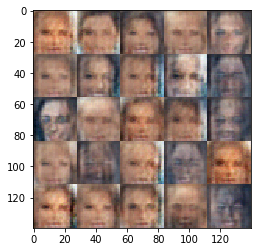

Epoch 0/1... Discriminator Loss: 0.3421... Generator Loss: 2.9154
Epoch 0/1... Discriminator Loss: 0.4251... Generator Loss: 3.1791
Epoch 0/1... Discriminator Loss: 0.3640... Generator Loss: 2.4906
Epoch 0/1... Discriminator Loss: 0.4538... Generator Loss: 2.6036
Epoch 0/1... Discriminator Loss: 0.3424... Generator Loss: 2.3955
Epoch 0/1... Discriminator Loss: 0.3700... Generator Loss: 1.9799
Epoch 0/1... Discriminator Loss: 0.3213... Generator Loss: 1.8429
Epoch 0/1... Discriminator Loss: 0.2872... Generator Loss: 3.5177
Epoch 0/1... Discriminator Loss: 0.4886... Generator Loss: 3.4298
Epoch 0/1... Discriminator Loss: 0.3442... Generator Loss: 2.0333


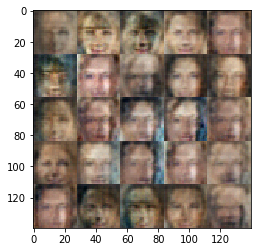

Epoch 0/1... Discriminator Loss: 0.4859... Generator Loss: 1.3390
Epoch 0/1... Discriminator Loss: 0.3271... Generator Loss: 2.2257
Epoch 0/1... Discriminator Loss: 0.6707... Generator Loss: 2.4246
Epoch 0/1... Discriminator Loss: 0.5707... Generator Loss: 1.8445
Epoch 0/1... Discriminator Loss: 0.3744... Generator Loss: 3.3149
Epoch 0/1... Discriminator Loss: 0.1731... Generator Loss: 3.1316
Epoch 0/1... Discriminator Loss: 0.4167... Generator Loss: 3.3422
Epoch 0/1... Discriminator Loss: 0.5424... Generator Loss: 1.3055
Epoch 0/1... Discriminator Loss: 0.4436... Generator Loss: 1.6734
Epoch 0/1... Discriminator Loss: 0.3414... Generator Loss: 1.9379


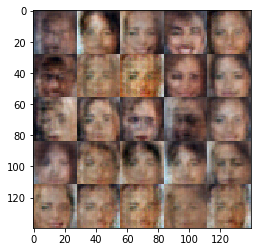

Epoch 0/1... Discriminator Loss: 0.3871... Generator Loss: 1.8563
Epoch 0/1... Discriminator Loss: 0.4061... Generator Loss: 3.1331
Epoch 0/1... Discriminator Loss: 0.4304... Generator Loss: 1.6992
Epoch 0/1... Discriminator Loss: 0.3634... Generator Loss: 1.8504
Epoch 0/1... Discriminator Loss: 0.8189... Generator Loss: 0.9097
Epoch 0/1... Discriminator Loss: 0.6472... Generator Loss: 0.9930
Epoch 0/1... Discriminator Loss: 0.5473... Generator Loss: 1.4103
Epoch 0/1... Discriminator Loss: 0.5440... Generator Loss: 2.0260
Epoch 0/1... Discriminator Loss: 0.3452... Generator Loss: 2.1513
Epoch 0/1... Discriminator Loss: 1.1998... Generator Loss: 6.1093


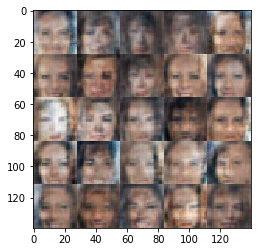

Epoch 0/1... Discriminator Loss: 1.9355... Generator Loss: 6.0709
Epoch 0/1... Discriminator Loss: 0.4728... Generator Loss: 1.7302
Epoch 0/1... Discriminator Loss: 0.4660... Generator Loss: 1.9757
Epoch 0/1... Discriminator Loss: 0.2618... Generator Loss: 3.1465
Epoch 0/1... Discriminator Loss: 0.3516... Generator Loss: 2.5162
Epoch 0/1... Discriminator Loss: 0.2449... Generator Loss: 3.3329
Epoch 0/1... Discriminator Loss: 1.2430... Generator Loss: 0.5568
Epoch 0/1... Discriminator Loss: 0.1994... Generator Loss: 2.9335
Epoch 0/1... Discriminator Loss: 0.4389... Generator Loss: 1.4755
Epoch 0/1... Discriminator Loss: 0.4747... Generator Loss: 1.4679


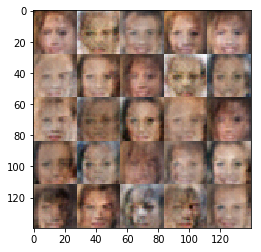

Epoch 0/1... Discriminator Loss: 0.4832... Generator Loss: 1.6430
Epoch 0/1... Discriminator Loss: 0.3402... Generator Loss: 3.0092
Epoch 0/1... Discriminator Loss: 0.4025... Generator Loss: 3.6178
Epoch 0/1... Discriminator Loss: 0.4901... Generator Loss: 1.9516
Epoch 0/1... Discriminator Loss: 0.8576... Generator Loss: 0.8647
Epoch 0/1... Discriminator Loss: 0.3812... Generator Loss: 2.4739
Epoch 0/1... Discriminator Loss: 0.4473... Generator Loss: 1.4157
Epoch 0/1... Discriminator Loss: 0.2673... Generator Loss: 3.1657
Epoch 0/1... Discriminator Loss: 0.5164... Generator Loss: 1.4107
Epoch 0/1... Discriminator Loss: 0.4025... Generator Loss: 1.7164


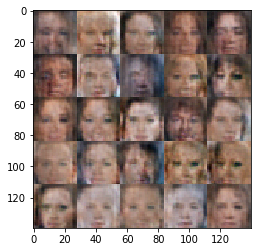

Epoch 0/1... Discriminator Loss: 0.3344... Generator Loss: 2.2041
Epoch 0/1... Discriminator Loss: 0.3381... Generator Loss: 4.3678
Epoch 0/1... Discriminator Loss: 0.3136... Generator Loss: 2.0452
Epoch 0/1... Discriminator Loss: 0.3345... Generator Loss: 1.8580
Epoch 0/1... Discriminator Loss: 1.0575... Generator Loss: 0.7428
Epoch 0/1... Discriminator Loss: 0.3354... Generator Loss: 2.0610
Epoch 0/1... Discriminator Loss: 0.3294... Generator Loss: 3.3019
Epoch 0/1... Discriminator Loss: 0.2896... Generator Loss: 2.7673
Epoch 0/1... Discriminator Loss: 0.8643... Generator Loss: 5.2376
Epoch 0/1... Discriminator Loss: 0.4878... Generator Loss: 2.7764


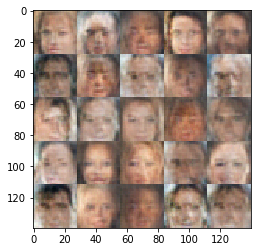

Epoch 0/1... Discriminator Loss: 0.3474... Generator Loss: 2.1264
Epoch 0/1... Discriminator Loss: 0.2885... Generator Loss: 2.4530
Epoch 0/1... Discriminator Loss: 0.2522... Generator Loss: 3.0214
Epoch 0/1... Discriminator Loss: 0.3995... Generator Loss: 1.8205
Epoch 0/1... Discriminator Loss: 0.6224... Generator Loss: 1.0683
Epoch 0/1... Discriminator Loss: 0.3469... Generator Loss: 2.5607
Epoch 0/1... Discriminator Loss: 0.5585... Generator Loss: 1.2067
Epoch 0/1... Discriminator Loss: 1.0796... Generator Loss: 0.6849
Epoch 0/1... Discriminator Loss: 0.6259... Generator Loss: 1.5578
Epoch 0/1... Discriminator Loss: 0.4140... Generator Loss: 2.1395


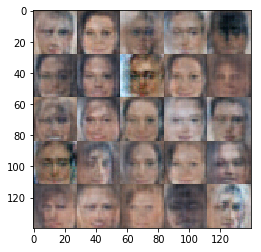

Epoch 0/1... Discriminator Loss: 0.4779... Generator Loss: 2.4811
Epoch 0/1... Discriminator Loss: 0.3389... Generator Loss: 3.1827
Epoch 0/1... Discriminator Loss: 0.5667... Generator Loss: 1.2703
Epoch 0/1... Discriminator Loss: 0.4276... Generator Loss: 2.6197
Epoch 0/1... Discriminator Loss: 0.3202... Generator Loss: 2.3568
Epoch 0/1... Discriminator Loss: 0.3877... Generator Loss: 1.5501
Epoch 0/1... Discriminator Loss: 0.3132... Generator Loss: 2.4699
Epoch 0/1... Discriminator Loss: 0.3419... Generator Loss: 2.7085
Epoch 0/1... Discriminator Loss: 0.4549... Generator Loss: 1.6749
Epoch 0/1... Discriminator Loss: 0.4374... Generator Loss: 1.4364


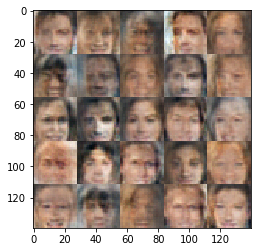

Epoch 0/1... Discriminator Loss: 0.5793... Generator Loss: 1.1692
Epoch 0/1... Discriminator Loss: 0.3218... Generator Loss: 2.9873
Epoch 0/1... Discriminator Loss: 0.2983... Generator Loss: 1.9545
Epoch 0/1... Discriminator Loss: 0.2161... Generator Loss: 2.7294
Epoch 0/1... Discriminator Loss: 0.8049... Generator Loss: 0.9246
Epoch 0/1... Discriminator Loss: 0.4051... Generator Loss: 3.1912
Epoch 0/1... Discriminator Loss: 0.6251... Generator Loss: 1.3375
Epoch 0/1... Discriminator Loss: 1.3718... Generator Loss: 0.4453
Epoch 0/1... Discriminator Loss: 0.4658... Generator Loss: 1.6175
Epoch 0/1... Discriminator Loss: 0.2413... Generator Loss: 2.5390


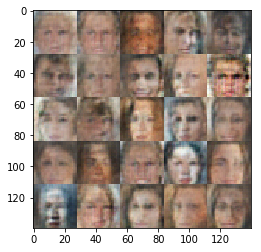

Epoch 0/1... Discriminator Loss: 0.5234... Generator Loss: 1.3061
Epoch 0/1... Discriminator Loss: 1.1186... Generator Loss: 0.5996
Epoch 0/1... Discriminator Loss: 0.3712... Generator Loss: 1.8830
Epoch 0/1... Discriminator Loss: 0.5585... Generator Loss: 3.2587
Epoch 0/1... Discriminator Loss: 0.2313... Generator Loss: 3.5317
Epoch 0/1... Discriminator Loss: 0.7285... Generator Loss: 1.0096
Epoch 0/1... Discriminator Loss: 0.5855... Generator Loss: 2.5536
Epoch 0/1... Discriminator Loss: 0.3520... Generator Loss: 1.7000
Epoch 0/1... Discriminator Loss: 0.5795... Generator Loss: 1.2906
Epoch 0/1... Discriminator Loss: 0.5708... Generator Loss: 1.2109


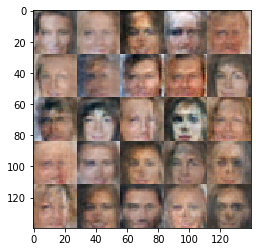

Epoch 0/1... Discriminator Loss: 0.3813... Generator Loss: 1.9435
Epoch 0/1... Discriminator Loss: 0.5153... Generator Loss: 1.3287
Epoch 0/1... Discriminator Loss: 0.5086... Generator Loss: 1.5052
Epoch 0/1... Discriminator Loss: 0.3439... Generator Loss: 3.3895
Epoch 0/1... Discriminator Loss: 0.5662... Generator Loss: 4.2303
Epoch 0/1... Discriminator Loss: 0.7088... Generator Loss: 3.0493
Epoch 0/1... Discriminator Loss: 0.3038... Generator Loss: 2.9176
Epoch 0/1... Discriminator Loss: 0.3057... Generator Loss: 2.0189
Epoch 0/1... Discriminator Loss: 0.2070... Generator Loss: 3.3293
Epoch 0/1... Discriminator Loss: 0.3421... Generator Loss: 2.0766


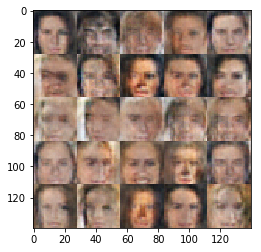

Epoch 0/1... Discriminator Loss: 0.6022... Generator Loss: 1.2825
Epoch 0/1... Discriminator Loss: 0.3573... Generator Loss: 2.8699
Epoch 0/1... Discriminator Loss: 0.3501... Generator Loss: 1.9683
Epoch 0/1... Discriminator Loss: 0.4053... Generator Loss: 1.7511
Epoch 0/1... Discriminator Loss: 0.6752... Generator Loss: 1.0739
Epoch 0/1... Discriminator Loss: 0.7849... Generator Loss: 0.9233
Epoch 0/1... Discriminator Loss: 0.3787... Generator Loss: 2.8951
Epoch 0/1... Discriminator Loss: 0.3533... Generator Loss: 1.7631
Epoch 0/1... Discriminator Loss: 0.6777... Generator Loss: 1.0335
Epoch 0/1... Discriminator Loss: 0.3390... Generator Loss: 2.5128


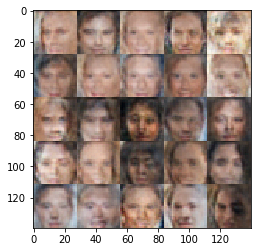

Epoch 0/1... Discriminator Loss: 0.2917... Generator Loss: 3.1271
Epoch 0/1... Discriminator Loss: 0.3655... Generator Loss: 3.0413
Epoch 0/1... Discriminator Loss: 0.4203... Generator Loss: 1.6147
Epoch 0/1... Discriminator Loss: 0.5936... Generator Loss: 1.1526
Epoch 0/1... Discriminator Loss: 0.4121... Generator Loss: 3.0777
Epoch 0/1... Discriminator Loss: 0.3129... Generator Loss: 2.1811
Epoch 0/1... Discriminator Loss: 0.6047... Generator Loss: 2.3972
Epoch 0/1... Discriminator Loss: 1.0929... Generator Loss: 5.0452
Epoch 0/1... Discriminator Loss: 0.3392... Generator Loss: 3.2890
Epoch 0/1... Discriminator Loss: 0.3543... Generator Loss: 2.0336


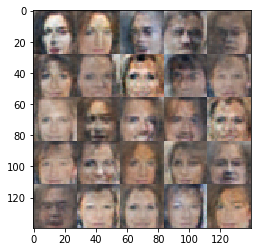

Epoch 0/1... Discriminator Loss: 0.4363... Generator Loss: 1.7659
Epoch 0/1... Discriminator Loss: 0.3633... Generator Loss: 3.1078
Epoch 0/1... Discriminator Loss: 0.2817... Generator Loss: 1.9380
Epoch 0/1... Discriminator Loss: 0.4468... Generator Loss: 1.8483
Epoch 0/1... Discriminator Loss: 0.9490... Generator Loss: 0.7662
Epoch 0/1... Discriminator Loss: 0.7533... Generator Loss: 3.3861
Epoch 0/1... Discriminator Loss: 0.3936... Generator Loss: 2.0097
Epoch 0/1... Discriminator Loss: 0.3374... Generator Loss: 2.1455
Epoch 0/1... Discriminator Loss: 0.4416... Generator Loss: 1.5512
Epoch 0/1... Discriminator Loss: 0.4545... Generator Loss: 1.6378


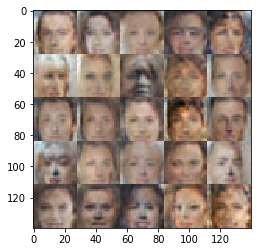

Epoch 0/1... Discriminator Loss: 0.2910... Generator Loss: 2.5040
Epoch 0/1... Discriminator Loss: 0.6380... Generator Loss: 1.1962
Epoch 0/1... Discriminator Loss: 0.4959... Generator Loss: 1.6302
Epoch 0/1... Discriminator Loss: 0.6555... Generator Loss: 4.0120
Epoch 0/1... Discriminator Loss: 0.5070... Generator Loss: 1.9667
Epoch 0/1... Discriminator Loss: 0.3618... Generator Loss: 1.7067
Epoch 0/1... Discriminator Loss: 0.4719... Generator Loss: 1.7415
Epoch 0/1... Discriminator Loss: 0.6713... Generator Loss: 1.1483
Epoch 0/1... Discriminator Loss: 0.2740... Generator Loss: 2.2191
Epoch 0/1... Discriminator Loss: 0.3699... Generator Loss: 1.9956


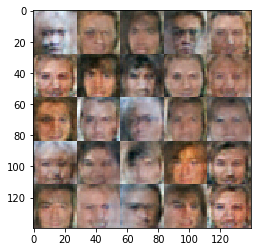

Epoch 0/1... Discriminator Loss: 0.1925... Generator Loss: 2.5793
Epoch 0/1... Discriminator Loss: 0.7006... Generator Loss: 1.1101
Epoch 0/1... Discriminator Loss: 3.8319... Generator Loss: 0.0469
Epoch 0/1... Discriminator Loss: 0.7172... Generator Loss: 1.1294
Epoch 0/1... Discriminator Loss: 0.4856... Generator Loss: 2.0995
Epoch 0/1... Discriminator Loss: 0.4645... Generator Loss: 1.9758
Epoch 0/1... Discriminator Loss: 0.3530... Generator Loss: 1.6950
Epoch 0/1... Discriminator Loss: 0.3404... Generator Loss: 2.2744
Epoch 0/1... Discriminator Loss: 0.3188... Generator Loss: 2.3812
Epoch 0/1... Discriminator Loss: 1.8237... Generator Loss: 0.3229


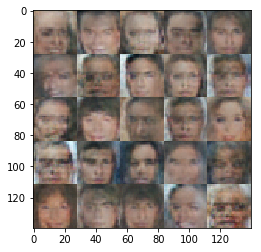

Epoch 0/1... Discriminator Loss: 0.5302... Generator Loss: 1.4806
Epoch 0/1... Discriminator Loss: 1.2013... Generator Loss: 0.6887
Epoch 0/1... Discriminator Loss: 0.6573... Generator Loss: 1.5872
Epoch 0/1... Discriminator Loss: 0.3121... Generator Loss: 2.0360
Epoch 0/1... Discriminator Loss: 0.2129... Generator Loss: 3.8403
Epoch 0/1... Discriminator Loss: 0.2367... Generator Loss: 3.2528
Epoch 0/1... Discriminator Loss: 0.3336... Generator Loss: 2.9385
Epoch 0/1... Discriminator Loss: 0.6062... Generator Loss: 1.0994
Epoch 0/1... Discriminator Loss: 1.0699... Generator Loss: 6.5183
Epoch 0/1... Discriminator Loss: 0.4997... Generator Loss: 1.4762


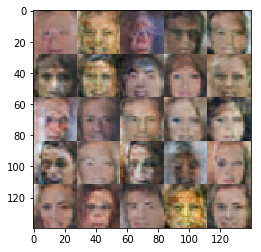

Epoch 0/1... Discriminator Loss: 0.3071... Generator Loss: 2.1551
Epoch 0/1... Discriminator Loss: 0.2731... Generator Loss: 2.5857
Epoch 0/1... Discriminator Loss: 0.6200... Generator Loss: 1.2653
Epoch 0/1... Discriminator Loss: 0.7478... Generator Loss: 0.8938
Epoch 0/1... Discriminator Loss: 0.4970... Generator Loss: 3.5171
Epoch 0/1... Discriminator Loss: 0.3803... Generator Loss: 1.7857
Epoch 0/1... Discriminator Loss: 0.4613... Generator Loss: 4.3953
Epoch 0/1... Discriminator Loss: 0.2550... Generator Loss: 2.3719
Epoch 0/1... Discriminator Loss: 0.3815... Generator Loss: 3.8118
Epoch 0/1... Discriminator Loss: 0.5326... Generator Loss: 1.5411


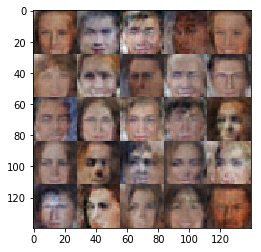

Epoch 0/1... Discriminator Loss: 0.2834... Generator Loss: 2.7845
Epoch 0/1... Discriminator Loss: 0.2248... Generator Loss: 2.2559
Epoch 0/1... Discriminator Loss: 0.4176... Generator Loss: 1.8839
Epoch 0/1... Discriminator Loss: 0.2663... Generator Loss: 3.1511
Epoch 0/1... Discriminator Loss: 0.3198... Generator Loss: 2.0384
Epoch 0/1... Discriminator Loss: 0.3944... Generator Loss: 2.0443


In [87]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)